In [2]:
import Pkg
using Pkg
Pkg.add("DrWatson")
using DrWatson

   Resolving package versions...
   Installed DrWatson ─ v2.13.0
    Updating `C:\Users\User\OneDrive\Documentos\Programacion\RockPaperScissors\Project.toml`
  [634d3b9d] + DrWatson v2.13.0
    Updating `C:\Users\User\OneDrive\Documentos\Programacion\RockPaperScissors\Manifest.toml`
  [c3fe647b] - AbstractAlgebra v0.27.10
  [621f4979] - AbstractFFTs v1.5.0
  [1520ce14] - AbstractTrees v0.3.4
  [79e6a3ab] - Adapt v3.7.2
  [dce04be8] - ArgCheck v2.3.0
  [ec485272] - ArnoldiMethod v0.2.0
  [4fba245c] - ArrayInterface v5.0.8
  [30b0a656] - ArrayInterfaceCore v0.1.29
  [6ba088a2] - ArrayInterfaceGPUArrays v0.2.2
  [dd5226c6] - ArrayInterfaceStaticArraysCore v0.1.4
  [a2b0951a] - ArrayInterfaceTracker v0.1.1
  [4c555306] - ArrayLayouts v0.8.18
  [a9b6321e] - Atomix v0.1.0
  [15f4f7f2] - AutoHashEquals v0.2.0
  [ab4f0b2a] - BFloat16s v0.2.0
  [aae01518] - BandedMatrices v0.17.18
  [198e06fe] - BangBang v0.3.40
  [9718e550] - Baselet v0.1.1
  [6e4b80f9] - BenchmarkTools v1.4.0
  [e2ed5e7c] - B

In [6]:
Pkg.add("DifferentialEquations")
Pkg.add("Plots")
Pkg.add("GalacticOptim")
Pkg.add("Flux")
using DifferentialEquations, Plots, GalacticOptim, Flux

   Resolving package versions...
   Installed FastAlmostBandedMatrices ─ v0.1.0
   Installed SteadyStateDiffEq ──────── v2.0.1
   Installed DifferentialEquations ──── v7.12.0
   Installed Sundials ───────────────── v4.23.2
   Installed DelayDiffEq ────────────── v5.46.0
   Installed BoundaryValueDiffEq ────── v5.6.0
   Installed BandedMatrices ─────────── v1.4.0
    Updating `C:\Users\User\OneDrive\Documentos\Programacion\RockPaperScissors\Project.toml`
  [0c46a032] + DifferentialEquations v7.12.0
    Updating `C:\Users\User\OneDrive\Documentos\Programacion\RockPaperScissors\Manifest.toml`
  [aae01518] + BandedMatrices v1.4.0
⌃ [764a87c0] + BoundaryValueDiffEq v5.6.0
  [bcd4f6db] + DelayDiffEq v5.46.0
  [0c46a032] + DifferentialEquations v7.12.0
  [9d29842c] + FastAlmostBandedMatrices v0.1.0
  [9672c7b4] + SteadyStateDiffEq v2.0.1
  [c3572dad] + Sundials v4.23.2
⌅ [fb77eaff] + Sundials_jll v5.2.2+0
        Info Packages marked with ⌃ and ⌅ have new versions available. Those with ⌃ may 

In [ ]:
using DrWatson
@quickactivate "RockPaperScissors"

In [5]:
using DrWatson
@quickactivate "RockPaperScissors"

using DiffEqFlux, DifferentialEquations, Plots, GalacticOptim
using Statistics: mean
using Flux.Losses: kldivergence

using Random
Random.seed!(235)

LoadError: ArgumentError: Package DifferentialEquations not found in current path.
- Run `import Pkg; Pkg.add("DifferentialEquations")` to install the DifferentialEquations package.

In [ ]:
# Function that will generate the data we are trying to fit
Payoff = [0.0f0 1 -1; -1 0 1; 1 -1 0];

function trueODEfunc(du, u, p, t)
    f = Payoff * u
    favg = mean(f)
    du .= u .* (f .- favg)
end

# Define the problem with the function above
u0 = Float32[1/2, 1/4, 1/4] # Initial condition
prob_trueode = ODEProblem(trueODEfunc, u0, (0.0f0, 15.0f0))

# Solve and take just the solution array
dt = 0.1f0
ode_data = Array(solve(prob_trueode, Vern7(), saveat=dt))

# Data Split
# n trayectories of length m/n for training
n = 10
m = 100
offset = div(m, n)
train_data = [ode_data[:, k:k+offset-1] for k=1:offset:m-offset+1]
# one trayectory of length 51 for testing
test_data = ode_data[:, 101:end]

scatter(ode_data[:, 1:100]', title="Data Sampling", label=["X training" "Y training" "Z training"])
plot!(ode_data', label=false)

: 

In [3]:
# Make a neural net with a NeuralODE layer
rbf(x) = exp.(-(x.^2))

NN = FastChain(
  FastDense(3,5, rbf), FastDense(5,9)
)

function dudt!(du, u, p, t)
  f = reshape(NN(u, p), (3, 3)) * u
  favg = mean(f)
  du .= u .* (f .- favg)
end

p0 = initial_params(NN)
prob = ODEProblem(dudt!, u0, (0.0f0, 0.9f0), p0)

# Array of predictions from NeuralODE with parameters p starting at initial condition u0
function predict(p, u0=u0, tspan=(0.0f0, 0.9f0))
  tmp_prob = remake(prob, u0=u0, p=p, tspan=tspan)
  Array(solve(tmp_prob, Rosenbrock23(), saveat=dt, 
    abstol=1e-3, reltol=1e-3, maxiters=1e5
    ))
end

predict (generic function with 3 methods)

In [4]:
function loss(p)
  l = 0.0f0#convert(eltype(p), 1e-2)*sum(abs2, p) ./ length(p)
  for i in 1:length(train_data)
    X = train_data[i]
    X̂ = predict(p, X[:,1])
    N = 10 #min(size(X ,2), size(X̂ ,2))
    # penalizer = true ? 1 : convert(eltype(p), 1e6) * 2.0f0 ^ (size(X,2) - N)
    l += sum(abs2, X .- X̂)
  end
  return l
end

function lyapunov(p)
  l = convert(eltype(p), 1e-3)*sum(abs2, p) ./ length(p)
  for i in 1:length(train_data)
    X = train_data[i]
    X̂ = predict(p, X[:,1])
    # N = min(size(X ,2), size(X̂ ,2))
    l += sum(kldivergence(X[:,j], X̂[:,j]) for j in 1:size(X, 2))
  end
  return l
end


# Callback to show the loss during training
losses = Float32[]
function callback(p, loss)
  push!(losses, loss)
  if length(losses)%50==0
      println("Current loss after $(length(losses)) iterations: $(losses[end])")
  end
  false
end

callback (generic function with 1 method)

In [9]:
losses = Float32[]
ADAMiters = 250
BFGSiters = 100
res1 = DiffEqFlux.sciml_train(
    loss, 
    prob.p, 
    ADAM(0.1f0), 
    cb = callback, 
    maxiters=ADAMiters
    )
res = DiffEqFlux.sciml_train(
    loss, 
    res1.minimizer, 
    BFGS(initial_stepnorm=0.01f0), 
    cb=callback, 
    maxiters = BFGSiters, 
    g_tol = 1e-10
    );

Current loss after 50 iterations: 0.0019687857
Current loss after 100 iterations: 3.1943277e-5
Current loss after 150 iterations: 6.2376243e-6
Current loss after 200 iterations: 1.9730567e-6
Current loss after 250 iterations: 1.2977505e-6


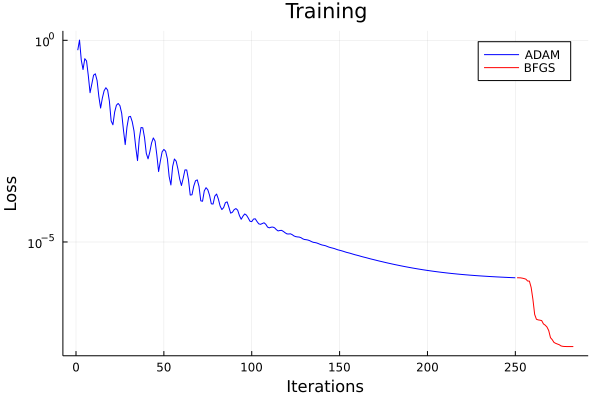

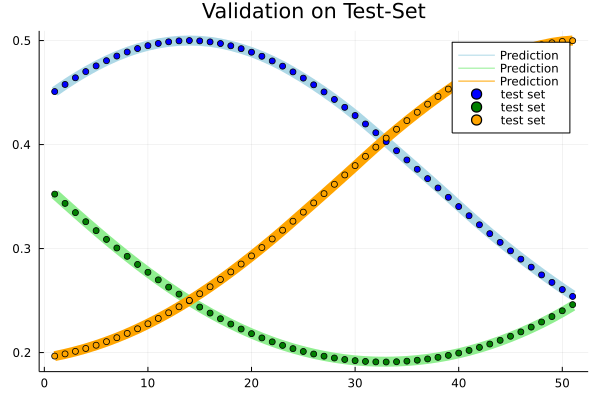

In [12]:
pl_losses = plot(1:ADAMiters, losses[1:ADAMiters], 
    yaxis = :log10, 
    xlabel = "Iterations", 
    ylabel = "Loss", 
    label = "ADAM", 
    color = :blue,
    title="Training"
)
idx = ADAMiters+1:length(losses)
pl_losses = plot!(idx, losses[idx], 
    label = "BFGS", 
    color = :red
) |> display

pred = predict(res.minimizer, test_data[:,1], (10.0f0, 15.0f0))
plot(pred', title="Validation on Test-Set", label="Prediction", lw=10, color=[:lightblue :lightgreen :orange])
scatter!(test_data', label="test set", color=[:blue :green :orange])